In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.metrics import log_loss, accuracy_score, classification_report, plot_confusion_matrix, balanced_accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
import seaborn as sns

from nltk import word_tokenize
from nltk.corpus import stopwords

%matplotlib inline
sns.set()

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample = pd.read_csv('../input/sample_submission.csv')

In [3]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train.author.values)

In [4]:
history = pd.DataFrame(
    [],
    columns=pd.MultiIndex.from_product([['train', 'validate'], ['logloss', 'accuracy']]),
    dtype='float32'
)

def evaluate_model(clf, slug, xtrain, ytrain, xvalid, yvalid, fit=True):
    global history
    if fit:
        clf.fit(xtrain, ytrain)

    if hasattr(clf, 'decision_function'):
        # print loss values
        df = clf.decision_function(xtrain)
        predictions = np.exp(df) / np.sum(np.exp(df), axis=1, keepdims=True)
        print ("train set: logloss: %0.3f" % (log_loss(ytrain, predictions), ))
        history.loc[slug, ('train', 'logloss')] = log_loss(ytrain, predictions)

        df = clf.decision_function(xvalid)
        predictions = np.exp(df) / np.sum(np.exp(df), axis=1, keepdims=True)
        print ("valid set: logloss: %0.3f" % (log_loss(yvalid, predictions), ))
        history.loc[slug, ('validate', 'logloss')] = log_loss(yvalid, predictions)
    else:
        # print loss values
        predictions = clf.predict_proba(xtrain)
        print ("train set: logloss: %0.3f" % (log_loss(ytrain, predictions), ))
        history.loc[slug, ('train', 'logloss')] = log_loss(ytrain, predictions)
        predictions = clf.predict_proba(xvalid)
        print ("valid set: logloss: %0.3f" % (log_loss(yvalid, predictions), ))
        history.loc[slug, ('validate', 'logloss')] = log_loss(yvalid, predictions)
    
    # print accuracy matrix
    predictions = clf.predict(xtrain)
    print('train set')
    print(classification_report(ytrain, predictions, target_names=lbl_enc.classes_, digits=3))
    print('-' * 70)
    predictions = clf.predict(xvalid)
    print('validate set')
    print(classification_report(yvalid, predictions, target_names=lbl_enc.classes_, digits=3))

    plot_confusion_matrix(clf, xvalid, yvalid, display_labels=lbl_enc.classes_, values_format='d', cmap='Blues')
    plt.grid(False)
    
    history.loc[slug, ('train', 'accuracy')] = balanced_accuracy_score(ytrain, clf.predict(xtrain))
    history.loc[slug, ('validate', 'accuracy')] = balanced_accuracy_score(yvalid, clf.predict(xvalid))

    return clf

## 训练样本拆分

e:\venvs\nlp\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


origin: [0.40349354 0.28780837 0.30869809]
train: [0.40349583 0.28778162 0.30872255]
valid: [0.40347293 0.28804903 0.30847804]


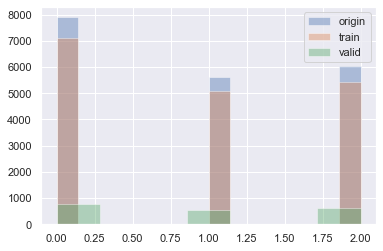

In [5]:
xtrain, xvalid, ytrain, yvalid = train_test_split(
    train.text.values, y, 
    stratify=y, 
    random_state=42, 
    test_size=0.1, shuffle=True
)
print('origin:', np.bincount(y)/len(y))
print('train:', np.bincount(ytrain)/len(ytrain))
print('valid:', np.bincount(yvalid)/len(yvalid))

## 载入GloVec词向量

In [6]:
with open('./data/glove.compress.embeddings.pickle', 'rb') as f:
    embeddings_index = pickle.load(f)

with open('./data/glove.compress.vocabulary.pickle', 'rb') as f:
    vocabulary = pickle.load(f)


## 特征提取

句子 --> 分词 --> 各词特征向量 --> 由词特征向量计算句向量

In [7]:
def sentence2vec(sentence, stopwords=set()):
    x = np.zeros(len(embeddings_index['a']))
    for w in word_tokenize(sentence):
        if w in stopwords:
            print('stopwords')
            continue
        if w not in embeddings_index:
            continue
        x += embeddings_index[w]
    return preprocessing.normalize([x])[0]

In [8]:
def sentence_array2vec(a, stopwords=set()):
    out = np.empty((len(a), 300))
    for idx, s in enumerate(a):
        out[idx] = sentence2vec(s)
    return out

## 训练

In [9]:
xtrain_glove_ns = sentence_array2vec(xtrain)
xvalid_glove_ns = sentence_array2vec(xvalid)

train set: logloss: 0.736
valid set: logloss: 0.751
train set
              precision    recall  f1-score   support

         EAP      0.758     0.688     0.721      7110
         HPL      0.696     0.746     0.720      5071
         MWS      0.700     0.739     0.719      5440

    accuracy                          0.720     17621
   macro avg      0.718     0.724     0.720     17621
weighted avg      0.723     0.720     0.720     17621

----------------------------------------------------------------------
validate set
              precision    recall  f1-score   support

         EAP      0.753     0.711     0.732       790
         HPL      0.694     0.738     0.715       564
         MWS      0.695     0.705     0.700       604

    accuracy                          0.717      1958
   macro avg      0.714     0.718     0.716      1958
weighted avg      0.718     0.717     0.717      1958



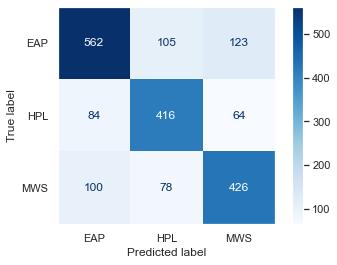

In [10]:
clf = evaluate_model(
    SVC(kernel='linear', class_weight='balanced'),
    'SVM linear kernel',
    xtrain_glove_ns, ytrain,
    xvalid_glove_ns, yvalid,
)

In [11]:
svd = TruncatedSVD(n_components=120)
svd.fit(np.r_[xtrain_glove_ns, xvalid_glove_ns])
xtrain_glove_ns_svd = svd.transform(xtrain_glove_ns)
xvalid_glove_ns_svd = svd.transform(xvalid_glove_ns)

train set: logloss: 0.765
valid set: logloss: 0.780
train set
              precision    recall  f1-score   support

         EAP      0.747     0.669     0.706      7110
         HPL      0.673     0.727     0.699      5071
         MWS      0.683     0.726     0.704      5440

    accuracy                          0.703     17621
   macro avg      0.701     0.707     0.703     17621
weighted avg      0.706     0.703     0.703     17621

----------------------------------------------------------------------
validate set
              precision    recall  f1-score   support

         EAP      0.743     0.682     0.712       790
         HPL      0.664     0.729     0.695       564
         MWS      0.686     0.697     0.691       604

    accuracy                          0.700      1958
   macro avg      0.698     0.703     0.699      1958
weighted avg      0.703     0.700     0.700      1958



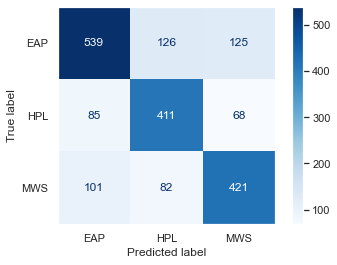

In [12]:
clf = evaluate_model(
    SVC(kernel='linear', class_weight='balanced'),
    'SVD+SVM linear kernel',
    xtrain_glove_ns_svd, ytrain,
    xvalid_glove_ns_svd, yvalid,
)

train set: logloss: 0.709
valid set: logloss: 0.756
train set
              precision    recall  f1-score   support

         EAP      0.777     0.702     0.738      7110
         HPL      0.710     0.760     0.734      5071
         MWS      0.712     0.756     0.734      5440

    accuracy                          0.735     17621
   macro avg      0.733     0.739     0.735     17621
weighted avg      0.738     0.735     0.736     17621

----------------------------------------------------------------------
validate set
              precision    recall  f1-score   support

         EAP      0.752     0.697     0.724       790
         HPL      0.690     0.722     0.705       564
         MWS      0.676     0.710     0.692       604

    accuracy                          0.708      1958
   macro avg      0.706     0.710     0.707      1958
weighted avg      0.710     0.708     0.709      1958



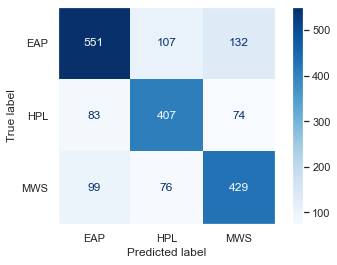

In [13]:
clf = evaluate_model(
    SVC(kernel='poly', class_weight='balanced'),
    'SVD+SVM poly kernel',
    xtrain_glove_ns_svd, ytrain,
    xvalid_glove_ns_svd, yvalid,
)

train set: logloss: 0.723
valid set: logloss: 0.763
train set
              precision    recall  f1-score   support

         EAP      0.769     0.694     0.730      7110
         HPL      0.701     0.754     0.726      5071
         MWS      0.706     0.747     0.726      5440

    accuracy                          0.727     17621
   macro avg      0.725     0.731     0.727     17621
weighted avg      0.730     0.727     0.728     17621

----------------------------------------------------------------------
validate set
              precision    recall  f1-score   support

         EAP      0.752     0.695     0.722       790
         HPL      0.686     0.720     0.702       564
         MWS      0.675     0.710     0.692       604

    accuracy                          0.707      1958
   macro avg      0.704     0.708     0.706      1958
weighted avg      0.709     0.707     0.707      1958



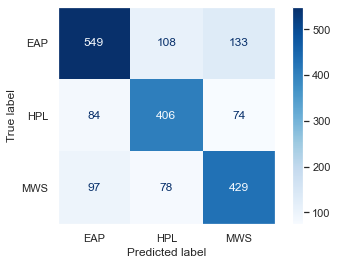

In [14]:
clf = evaluate_model(
    SVC(kernel='rbf', class_weight='balanced'),
    'SVD+SVM RBF kernel',
    xtrain_glove_ns_svd, ytrain,
    xvalid_glove_ns_svd, yvalid,
)

train set: logloss: 0.777
valid set: logloss: 0.783
train set
              precision    recall  f1-score   support

         EAP      0.734     0.697     0.715      7110
         HPL      0.682     0.718     0.700      5071
         MWS      0.700     0.711     0.706      5440

    accuracy                          0.707     17621
   macro avg      0.705     0.709     0.707     17621
weighted avg      0.708     0.707     0.708     17621

----------------------------------------------------------------------
validate set
              precision    recall  f1-score   support

         EAP      0.730     0.713     0.721       790
         HPL      0.680     0.700     0.690       564
         MWS      0.695     0.697     0.696       604

    accuracy                          0.704      1958
   macro avg      0.702     0.703     0.702      1958
weighted avg      0.705     0.704     0.704      1958



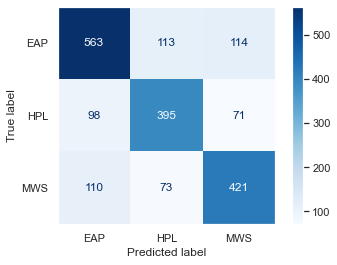

In [15]:
clf = evaluate_model(
    LinearSVC(class_weight='balanced'),
    'SVD+LinearSVC',
    xtrain_glove_ns_svd, ytrain,
    xvalid_glove_ns_svd, yvalid,
)

In [16]:
history.sort_values(by=('validate', 'logloss'))

train            validate          
                        logloss  accuracy   logloss  accuracy
SVM linear kernel      0.735733  0.724134  0.750535  0.718093
SVD+SVM poly kernel    0.709209  0.739376  0.756131  0.709788
SVD+SVM RBF kernel     0.722749  0.731475  0.762915  0.708353
SVD+SVM linear kernel  0.764583  0.707149  0.780307  0.702674
SVD+LinearSVC          0.777261  0.708741  0.782929  0.703344